In [1]:
# Load packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from pandas import concat
from matplotlib.pyplot import subplots
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, lasso_path, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [33]:
# Import data
data = pd.read_stata("updated_fl.dta")

# Convert Categorical variables: List of categorical columns
categorical_cols = ['race','sex','custody_description']

# Create an instance of LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in categorical_cols:
    data[col+ '_encoded'] = le.fit_transform(data[col])
    
# Select columns
data = data.select_dtypes(include=['number'])

In [34]:
# Remove missing observations
dataset = data.dropna()
data.shape
dataset.shape

(129531, 82)

In [4]:
################################ summary statistics on recidivism ###########################################

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import data
dataset = pd.read_stata("updated_fl.dta")

# subset of data
selected = ['anyrecid','offenderid','race','sex','under30','ban']
df = dataset[selected]

# Define the mapping
replacement_map = {
    'A': 'Asian',
    'B': 'Black',
    'I': 'American Indian',
    'W': 'White',
    # If 'U' should also be replaced, add it here; otherwise, leave it out.
    'U': 'Unknown'  # Example replacement for 'U'
}

# Replace values in the 'race' column
df['race'] = df['race'].replace(replacement_map)

# Convert 'under30' to a categorical variable
df['under30'] = df['under30'].map({1: 'Under 30', 0: '30 or Older'})

# Calculate the proportion of recidivism by race and sex
recidivism_rates = df.groupby(['race', 'sex','ban'])['anyrecid'].mean().reset_index()

# Rename the recidivism column to make it clear
recidivism_rates.rename(columns={'anyrecid': 'recidivism_rate'}, inplace=True)
print(df)

        anyrecid offenderid   race sex      under30  ban
0            0.0    A000019  White   M     Under 30  NaN
1            1.0    A000043  Black   M     Under 30  0.0
2            0.0    A000043  Black   M  30 or Older  0.0
3            1.0    A000077  White   M  30 or Older  0.0
4            0.0    A000077  White   M  30 or Older  0.0
...          ...        ...    ...  ..          ...  ...
493851       0.0    Z442316  White   M  30 or Older  0.0
493852       0.0    Z442354  Black   M  30 or Older  0.0
493853       0.0    Z442416  White   M     Under 30  0.0
493854       1.0    Z442436  White   M     Under 30  0.0
493855       0.0    Z442436  White   M  30 or Older  0.0

[493856 rows x 6 columns]


/var/folders/1x/fvyxnz7d5db2mw8jz8k69snr0000gn/T/ipykernel_27203/3604850278.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['race'] = df['race'].replace(replacement_map)
/var/folders/1x/fvyxnz7d5db2mw8jz8k69snr0000gn/T/ipykernel_27203/3604850278.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['under30'] = df['under30'].map({1: 'Under 30', 0: '30 or Older'})


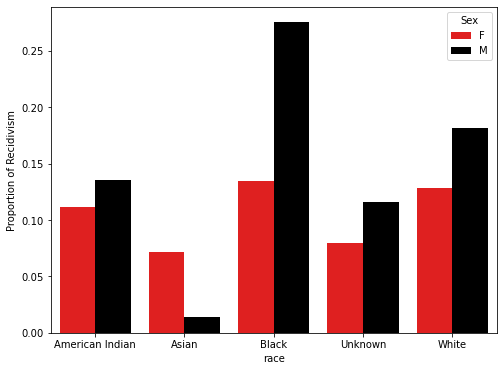

In [6]:
# Create a barplot to visualize the proportions
plt.figure(figsize=(8,6))
sns.barplot(x='race', y='recidivism_rate', hue='sex', data=recidivism_rates, palette=['red', 'black'], ci = None)

# Add labels and title
plt.ylabel('Proportion of Recidivism')
plt.legend(title='Sex')

# Save figure
plt.savefig('figure1.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show();

In [7]:
# Group by 'ban' and 'sex', and count the number of occurrences
ban_sex_counts = df.groupby(['ban', 'sex']).size().reset_index(name='count')

# Display the result
print(ban_sex_counts)

   ban sex   count
0  0.0   F   46196
1  0.0   M  349796
2  1.0   F    2481
3  1.0   M   16369


In [8]:
# Group by 'race' and 'ban', and count the number of occurrences
ban_race_counts = df.groupby(['ban', 'race']).size().reset_index(name='count')

# Display the result
print(ban_race_counts)

   ban             race   count
0  0.0  American Indian     350
1  0.0            Asian      42
2  0.0            Black  196429
3  0.0          Unknown     762
4  0.0            White  198409
5  1.0  American Indian       9
6  1.0            Asian       4
7  1.0            Black    7122
8  1.0          Unknown      82
9  1.0            White   11633


In [9]:
# Group by 'ban' and 'age', and count the number of occurrences
ban_age_counts = df.groupby(['ban', 'under30']).size().reset_index(name='count')

# Display the result
print(ban_age_counts)

   ban      under30   count
0  0.0  30 or Older  225261
1  0.0     Under 30  170728
2  1.0  30 or Older   10986
3  1.0     Under 30    7864


In [10]:
# Group by 'recidivism' and 'sex', and count the number of occurrences
recid_sex_counts = df.groupby(['anyrecid', 'sex']).size().reset_index(name='count')

# Display the result
print(recid_sex_counts)

   anyrecid sex   count
0       0.0   F   44908
1       0.0   M  321872
2       1.0   F    9708
3       1.0   M  117368


In [11]:
# Group by 'race' and 'recidivism', and count the number of occurrences
recid_race_counts = df.groupby(['anyrecid', 'race']).size().reset_index(name='count')

# Display the result
print(recid_race_counts)

   anyrecid             race   count
0       0.0  American Indian     317
1       0.0            Asian      59
2       0.0            Black  167548
3       0.0          Unknown     964
4       0.0            White  197892
5       1.0  American Indian      92
6       1.0            Asian       2
7       1.0            Black   75498
8       1.0          Unknown     134
9       1.0            White   51350


In [12]:
# Group by 'recidivism' and 'age', and count the number of occurrences
recid_age_counts = df.groupby(['anyrecid', 'under30']).size().reset_index(name='count')

# Display the result
print(recid_age_counts)

   anyrecid      under30   count
0       0.0  30 or Older  217013
1       0.0     Under 30  149764
2       1.0  30 or Older   65310
3       1.0     Under 30   61766


In [13]:
################################## Summary Statistics - Quantitative Covariates ##################################

In [14]:
# summary statistics
select = ['offenderid','totalyearssentenced','age','unemp_rate','sex','race']
dframe = dataset[select]
dframe.describe()
dframe.describe(include = 'all')

,offenderid,totalyearssentenced,age,unemp_rate,sex,race
count,493856,493856.000000,493853.000000,405009.000000,493856,493856
unique,366781,NaN,NaN,NaN,2,5
top,X330544,NaN,NaN,NaN,M,W
freq,11,NaN,NaN,NaN,439240,249242
mean,NaN,7.686532,33.444995,6.070069,NaN,NaN
std,NaN,31.939896,10.733691,2.841336,NaN,NaN
min,NaN,0.041096,13.000000,1.400000,NaN,NaN
25%,NaN,1.493151,25.000000,3.700000,NaN,NaN
50%,NaN,2.328767,32.000000,5.300000,NaN,NaN
75%,NaN,4.443836,41.000000,8.300000,NaN,NaN


In [15]:
########################## Regression Results and Other Models #######################################

In [16]:
# Load packages
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression

In [17]:
# Import dataset again
dataset = pd.read_stata('updated_fl.dta')

In [18]:
# Set variables
x = dataset.drop(columns = ['anyrecid',"offenderid"])
y = dataset['anyrecid']

In [19]:
# Logistic regression using statsmodels
logit_model = smf.logit('anyrecid ~ ban * unemp_rate', data=dataset).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.597797
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               anyrecid   No. Observations:               403398
Model:                          Logit   Df Residuals:                   403394
Method:                           MLE   Df Model:                            3
Date:                Sun, 03 Nov 2024   Pseudo R-squ.:                 0.02669
Time:                        09:57:03   Log-Likelihood:            -2.4115e+05
converged:                       True   LL-Null:                   -2.4776e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0672      0.008     -8.183      0.000      -0.083      -0.051
ban              

In [35]:
import warnings

# Suppress all warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")    
    # Ols Regression accross the different population groups
    groups = dataset.groupby(['race', 'sex'])

    for (race, sex), group_data in groups:
        print(f"\nOLS for Race: {race}, Sex: {sex}")

        # Drop rows with missing values for the variables used in the model
        group_data = group_data.dropna(subset=['anyrecid', 'ban', 'unemp_rate'])

        # If group_data is empty after dropping NaNs, skip to the next group
        if group_data.empty:
            print(f"Skipping OLS for Race: {race}, Sex: {sex} due to no valid data.")
            continue

        # Fit the OLS model
        reg = smf.logit('anyrecid ~ ban * unemp_rate', data=group_data).fit()
        print(reg.summary())

KeyError: 'race'

In [21]:
####################################### Ridge and Lasso ##########################################################

In [22]:
#============================================= Ridge =============================================================#

In [36]:
# Load packages
from sklearn.linear_model import Ridge 
from sklearn.metrics import mean_squared_error as mse

In [38]:
# Define variables
X = dataset.drop(columns = ["anyrecid","distn2","distn3","distn4","finrecidany","nonfinrecidany"])
Y = dataset["anyrecid"]
feature_names = dataset.columns

In [39]:
print(dataset.shape)

(129531, 82)


In [40]:
# Standardize variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [41]:
import warnings

# Suppress all warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

# Set up a range of lambdas
    lambdas = 10**np.linspace(5, -5, 100) / Y.std()
    soln_array = skl.ElasticNet.path(X_scaled,
                                     Y,
                                     l1_ratio=0,
                                     alphas=lambdas)[1]
    print(soln_array.shape)

(76, 100)


In [42]:
# Transform Soln_path into a dataframe
soln_path = pd.DataFrame(soln_array.T,
                         columns=X.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,index,date,adate,rdate,releaseyear,releasemonth,after,dist,distnoab,fullbanafter,...,countoffenses,preoct97,placebodrug,placebosmd,year,month,unemp_rate,race_encoded,sex_encoded,custody_description_encoded
negative log(lambda),,,,,,,,,,,,,,,,,,,,,
-12.239637,-2.172437e-09,-7.088776e-07,-7.899945e-07,-8.088295e-07,-8.073735e-07,1.856344e-09,-1.560161e-07,-7.109175e-07,-7.088776e-07,0.0,...,7.302167e-08,0.0,0.0,2.036241e-08,-8.073735e-07,1.856344e-09,-4.122454e-07,-3.429163e-07,2.490411e-07,6.039701e-08
-12.007053,-2.741294e-09,-8.944875e-07,-9.968453e-07,-1.020613e-06,-1.018775e-06,2.342276e-09,-1.968652e-07,-8.970616e-07,-8.944875e-07,0.0,...,9.214255e-08,0.0,0.0,2.569376e-08,-1.018775e-06,2.342276e-09,-5.201863e-07,-4.327080e-07,3.142524e-07,7.621189e-08
-11.774469,-3.459104e-09,-1.128692e-06,-1.257853e-06,-1.287844e-06,-1.285526e-06,2.955356e-09,-2.484081e-07,-1.131940e-06,-1.128692e-06,0.0,...,1.162702e-07,0.0,0.0,3.242075e-08,-1.285526e-06,2.955356e-09,-6.563874e-07,-5.460104e-07,3.965386e-07,9.616770e-08
-11.541884,-4.364867e-09,-1.424211e-06,-1.587193e-06,-1.625038e-06,-1.622113e-06,3.728820e-09,-3.134433e-07,-1.428309e-06,-1.424211e-06,0.0,...,1.467155e-07,0.0,0.0,4.090860e-08,-1.622113e-06,3.728820e-09,-8.282459e-07,-6.889787e-07,5.003703e-07,1.213486e-07
-11.309300,-5.507795e-09,-1.797091e-06,-2.002751e-06,-2.050507e-06,-2.046815e-06,4.704575e-09,-3.955013e-07,-1.802263e-06,-1.797091e-06,0.0,...,1.851325e-07,0.0,0.0,5.161803e-08,-2.046815e-06,4.704575e-09,-1.045094e-06,-8.693793e-07,6.313883e-07,1.531226e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.855876,-8.486236e-04,2.014793e-03,-1.122461e-01,-1.040727e-01,5.293422e-02,2.811389e-03,1.512947e-02,-3.848466e-02,3.498098e-02,0.0,...,9.254441e-03,0.0,0.0,1.023165e-03,2.538564e-02,1.978229e-03,7.409613e-03,-4.249628e-03,1.228610e-02,1.298354e-03
10.088461,-8.487291e-04,-1.137183e-03,-1.129582e-01,-1.117178e-01,6.290378e-02,3.380383e-03,1.504908e-02,-4.107565e-02,3.473117e-02,0.0,...,9.501754e-03,0.0,0.0,1.017052e-03,3.082835e-02,2.357656e-03,7.409554e-03,-4.186160e-03,1.229029e-02,1.298081e-03
10.321045,-8.488448e-04,-4.457789e-03,-1.135632e-01,-1.195784e-01,7.324656e-02,3.973647e-03,1.497712e-02,-4.339556e-02,3.416492e-02,0.0,...,9.761332e-03,0.0,0.0,1.003989e-03,3.633482e-02,2.739867e-03,7.409522e-03,-4.133363e-03,1.228908e-02,1.297786e-03


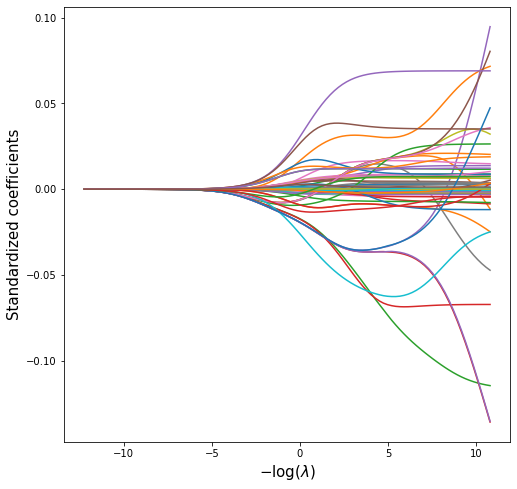

In [43]:
# Plot the graph
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=15)
ax.set_ylabel('Standardized coefficients', fontsize=15);
#ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.005))
#ax.set_title('Ridge Regression Coefficient Path', fontsize=21); 
#ax.set_ylim([-0.1,0.4]);
# save the figure
plt.savefig('ridge.png', format = 'png',dpi=300, bbox_inches='tight')

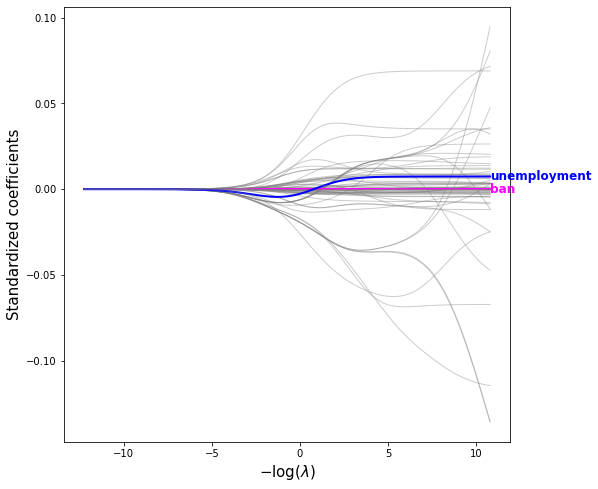

In [44]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))

# Plot all the coefficient paths
soln_path.plot(ax=ax, legend=False)

# List of variables you want to highlight with their specific colors and custom labels
highlight_vars = {'ban': ('magenta', 'ban'), 'unemp_rate': ('blue', 'unemployment')}

# Iterate over the plotted lines
for i, line in enumerate(ax.get_lines()):
    var_name = soln_path.columns[i]  
    
    # Check if the current variable is one to highlight
    if var_name in highlight_vars:
        color, label = highlight_vars[var_name] 
        line.set_color(color)  
        line.set_linewidth(2)  

        # Annotate the line with the custom label at the end of the curve
        x_data = line.get_xdata()[-1] 
        y_data = line.get_ydata()[-1]  
        ax.text(x_data, y_data, label, color=color, fontsize=12, fontweight='bold',
                verticalalignment='center', horizontalalignment='left')  
    else:
        # Fade the other variables
        line.set_color(to_rgba('gray', alpha=0.4))  
        line.set_linewidth(1)  

# Set labels and title
ax.set_xlabel('$-\log(\lambda)$', fontsize=15)
ax.set_ylabel('Standardized coefficients', fontsize=15)
#ax.set_title('Ridge Regression Coefficient Path', fontsize=21)
ax.legend().set_visible(False)

# save the figure
plt.savefig('ridge_faded.png', format='png', dpi=300, bbox_inches='tight')

plt.show();

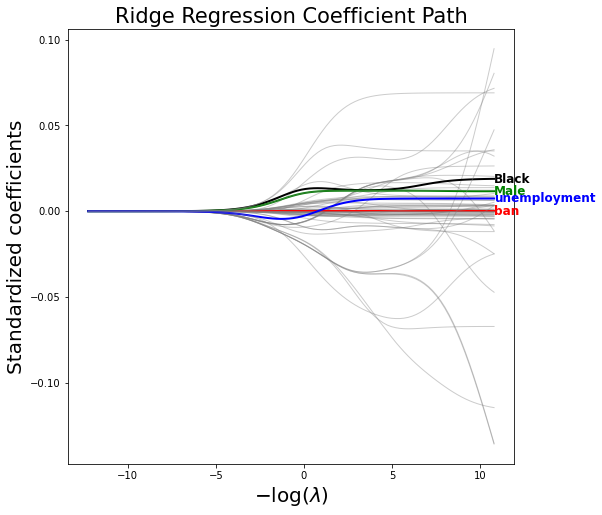

In [45]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))

# Plot all the coefficient paths
soln_path.plot(ax=ax, legend=False)

# List of variables you want to highlight with their specific colors and custom labels
highlight_vars = {
    'ban': ('red', 'ban'),
    'unemp_rate': ('blue', 'unemployment'),
    'black': ('black', 'Black'),  
    'male': ('green', 'Male')      
}

# Iterate over the plotted lines
for i, line in enumerate(ax.get_lines()):
    var_name = soln_path.columns[i]  
    
    # Check if the current variable is one to highlight
    if var_name in highlight_vars:
        color, label = highlight_vars[var_name]  
        line.set_color(color)  
        line.set_linewidth(2)  
        
        # Annotate the line with the custom label at the end of the curve
        x_data = line.get_xdata()[-1]  
        y_data = line.get_ydata()[-1]  
        ax.text(x_data, y_data, label, color=color, fontsize=12, fontweight='bold',
                verticalalignment='center', horizontalalignment='left')  
    else:
        # Fade the other variables
        line.set_color(to_rgba('gray', alpha=0.4))  
        line.set_linewidth(1) 

# Set labels and title
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.set_title('Ridge Regression Coefficient Path', fontsize=21)
ax.legend().set_visible(False)

plt.show();

In [46]:
# Import data
dt = pd.read_stata("updated_fl.dta")

# Convert Categorical variables: List of categorical columns
categorical_cols = ['race','sex','custody_description']

# Create an instance of LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in categorical_cols:
    dt[col+ '_encoded'] = le.fit_transform(dt[col])
    
# Select columns
dt = dt.select_dtypes(include=['number'])

In [47]:
# Missing values
dtf = dt.dropna()

In [48]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import warnings

# Load your data
dtf = pd.read_stata("updated_fl.dta")

# Check the shape of the original dataset
print("Original dataset shape:", dtf.shape)

# Filter the dataset for the affected group
affected_group = dtf[dtf['ban'] == 1]

# Check if the affected group is empty
if affected_group.empty:
    print("No data for the affected group where 'ban' == 1.")
else:
    print("Affected group shape:", affected_group.shape)

    # Select features and target variable
    X1 = affected_group.drop(columns=["anyrecid", "distn2", "distn3",
                                      "distn4", "finrecidany", "nonfinrecidany",
                                      "offenderid","placebodrug"])  
    
    # Only keep numeric columns
    X1_numeric = X1.select_dtypes(include=[np.number])  
    
    y = affected_group['anyrecid']  

    # Check for NaN values and handle them
    nan_count = X1_numeric.isna().sum()
    print("NaN values in each feature before handling:\n", nan_count[nan_count > 0])
    
    # Impute NaN values with mean
    imputer = SimpleImputer(strategy='mean')
    X1_numeric_imputed = imputer.fit_transform(X1_numeric)
    
    # Check if imputation resulted in an empty array
    if X1_numeric_imputed.size == 0:
        print("Feature set is empty after imputation.")
    else:
        print("Feature set shape after imputation:", X1_numeric_imputed.shape)
        
        # Standardize the features
        scaler = StandardScaler()
        X1_scaled = scaler.fit_transform(X1_numeric_imputed)

        # Suppress all warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            # Set up a range of lambdas
            lambdas1 = 10**np.linspace(5, -5, 100) / y.std()

            # Use ElasticNet to get the solution path
            soln_array1 = ElasticNet.path(X1_scaled, y, l1_ratio=0, alphas=lambdas1)[1]
            print(soln_array1.shape)    
            
            # Transform Soln_path into a dataframe with the correct column names
            soln_path1 = pd.DataFrame(soln_array1.T,
                                      columns=X1_numeric.columns,  # Use the correct column names
                                      index=-np.log(lambdas1))
            soln_path1.index.name = 'negative log(lambda)'
soln_path1

Original dataset shape: (493856, 88)
Affected group shape: (18850, 88)
NaN values in each feature before handling:
 assault         2335
elderly         2335
escape          2335
forgery         2335
fraud           2335
kidnap          2335
manslaughter    2335
murder          2335
othercrime      2335
otherviolent    2335
propdamage      2335
racketeer       2335
robbery         2335
sexcrime        2335
propsteal       2335
weapon          2335
year             392
month            392
unemp_rate       392
dtype: int64
Feature set shape after imputation: (18850, 72)
(72, 100)


,index,date,adate,rdate,releaseyear,releasemonth,after,dist,distnoab,fullbanafter,...,male,totalyearssentenced,prioroffensenumber,prioroffense,countoffenses,preoct97,placebosmd,year,month,unemp_rate
negative log(lambda),,,,,,,,,,,,,,,,,,,,,
-12.651551,8.727400e-09,-1.642660e-07,-1.830171e-07,-2.081831e-07,-2.075602e-07,-1.689272e-09,-2.569627e-08,-1.650950e-07,-1.642660e-07,-2.569627e-08,...,6.977708e-08,-5.179995e-08,1.162377e-07,1.225094e-07,1.157785e-07,0.0,0.0,-2.053247e-07,-3.873092e-10,-7.268024e-08
-12.418967,1.101267e-08,-2.072780e-07,-2.309392e-07,-2.626951e-07,-2.619091e-07,-2.131644e-09,-3.242419e-08,-2.083240e-07,-2.072780e-07,-3.242419e-08,...,8.804840e-08,-6.536429e-08,1.466753e-07,1.545892e-07,1.460954e-07,0.0,0.0,-2.590881e-07,-4.887503e-10,-9.171092e-08
-12.186382,1.389633e-08,-2.615516e-07,-2.914086e-07,-3.314801e-07,-3.304882e-07,-2.689870e-09,-4.091339e-08,-2.628715e-07,-2.615516e-07,-4.091339e-08,...,1.111040e-07,-8.248065e-08,1.850830e-07,1.950693e-07,1.843508e-07,0.0,0.0,-3.269286e-07,-6.167671e-10,-1.157242e-07
-11.953798,1.753503e-08,-3.300350e-07,-3.677102e-07,-4.182748e-07,-4.170232e-07,-3.394294e-09,-5.162476e-08,-3.317006e-07,-3.300350e-07,-5.162476e-08,...,1.401966e-07,-1.040792e-07,2.335480e-07,2.461492e-07,2.326231e-07,0.0,0.0,-4.125316e-07,-7.783263e-10,-1.460245e-07
-11.721214,2.212647e-08,-4.164479e-07,-4.639885e-07,-5.277939e-07,-5.262146e-07,-4.283214e-09,-6.513975e-08,-4.185496e-07,-4.164479e-07,-6.513975e-08,...,1.769069e-07,-1.313338e-07,2.947038e-07,3.106046e-07,2.935352e-07,0.0,0.0,-5.205469e-07,-9.822231e-10,-1.842575e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.443962,1.311936e-03,-4.127533e-02,-8.036266e-02,-1.209647e-02,-9.525821e-03,-2.543621e-02,8.207500e-03,1.295227e-01,-7.166471e-02,2.690727e-03,...,1.373648e-02,-9.515366e-03,2.297853e-02,2.374356e-02,4.385053e-03,0.0,0.0,2.385287e-03,2.506225e-02,9.054810e-03
9.676547,1.312867e-03,-4.434591e-02,-8.103070e-02,-1.166005e-02,-8.881416e-03,-2.543795e-02,8.454121e-03,1.366016e-01,-7.712833e-02,2.695200e-03,...,1.373711e-02,-9.118594e-03,2.298236e-02,2.374022e-02,4.356431e-03,0.0,0.0,2.404937e-03,2.510632e-02,9.054105e-03
9.909131,1.313641e-03,-4.747516e-02,-8.162520e-02,-1.130413e-02,-8.247846e-03,-2.543110e-02,8.658571e-03,1.430525e-01,-8.224801e-02,2.716561e-03,...,1.373767e-02,-8.666737e-03,2.298585e-02,2.373720e-02,4.332672e-03,0.0,0.0,2.419611e-03,2.514080e-02,9.053531e-03


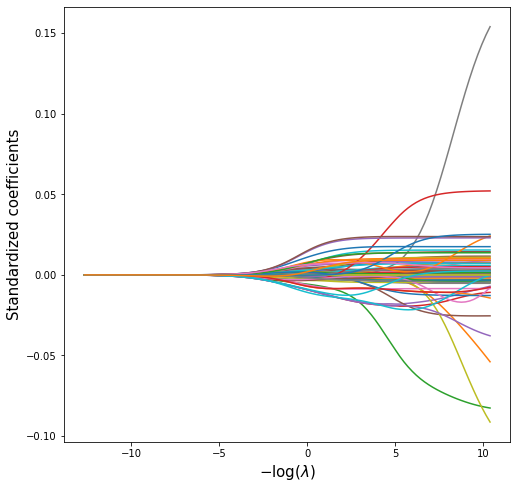

In [49]:
# Plot the graph
path_fig, ax = subplots(figsize=(8,8))
soln_path1.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=15)
ax.set_ylabel('Standardized coefficients', fontsize=15);
#ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.005))
#ax.set_title('Ridge Regression Coefficient Path', fontsize=21); 
#ax.set_ylim([-0.1,0.4]);
# save the figure
plt.savefig('ridge_ban.png', format = 'png',dpi=300, bbox_inches='tight')

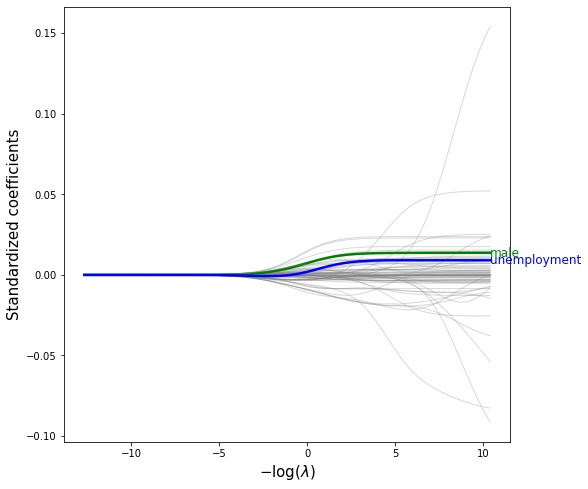

In [50]:
import matplotlib.pyplot as plt

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))

# Define the covariates you want to highlight, their corresponding labels, and custom colors
highlight_covariates = {
    'unemp_rate': {'label': 'unemployment', 'color': 'blue'},
    'male': {'label': 'male', 'color': 'green'}
}

# Plot each covariate line
for covariate in soln_path1.columns:
    if covariate in highlight_covariates:
        # Highlight these covariates with specific colors and bold lines
        label_info = highlight_covariates[covariate]
        soln_path1[covariate].plot(ax=ax, label=label_info['label'], color=label_info['color'], linewidth=2.5, alpha=1.0)
        
        # Add label to the right side of the curve (at the last point)
        rightmost_point = soln_path1[covariate].index[-1]  # Last index
        rightmost_value = soln_path1[covariate].iloc[-1]   # Last value
        ax.text(x=rightmost_point, y=rightmost_value, 
                s=label_info['label'], fontsize=12, color=label_info['color'],
                verticalalignment='center', horizontalalignment='left')
    else:
        # Fade other covariates with lighter color and transparency
        soln_path1[covariate].plot(ax=ax, color='gray', linewidth=1, alpha=0.3)

# Add labels for axes
ax.set_xlabel('$-\log(\lambda)$', fontsize=15)
ax.set_ylabel('Standardized coefficients', fontsize=15)

# Save the figure
plt.savefig('ridge_ban_labels.png', format='png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

In [51]:
# Ridge for the group of offenders not affected by the ban
# Load your data
dtfr = pd.read_stata("updated_fl.dta")

# Check the shape of the original dataset
print("Original dataset shape:", dtf.shape)

# Filter the dataset for the affected group
affected_group_1 = dtfr[dtfr['ban'] == 0]

# Check if the affected group is empty
if affected_group_1.empty:
    print("No data for the affected group where 'ban' == 0.")
else:
    print("Affected group shape:", affected_group_1.shape)

    # Select features and target variable
    X_1 = affected_group_1.drop(columns=["anyrecid", "distn2", "distn3",
                                      "distn4", "finrecidany", "nonfinrecidany",
                                      "offenderid","placebodrug"])  
    
    # Only keep numeric columns
    X_1_numeric = X_1.select_dtypes(include=[np.number])  
    
    y_1 = affected_group_1['anyrecid']  

    # Check for NaN values and handle them
    nan_count = X_1_numeric.isna().sum()
    print("NaN values in each feature before handling:\n", nan_count[nan_count > 0])
    
    # Impute NaN values with mean
    imputer_1 = SimpleImputer(strategy='mean')
    X_1_numeric_imputed = imputer_1.fit_transform(X_1_numeric)
    
    # Check if imputation resulted in an empty array
    if X_1_numeric_imputed.size == 0:
        print("Feature set is empty after imputation.")
    else:
        print("Feature set shape after imputation:", X_1_numeric_imputed.shape)
        
        # Standardize the features
        scaler = StandardScaler()
        X_1_scaled = scaler.fit_transform(X_1_numeric_imputed)

        # Suppress all warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            # Set up a range of lambdas
            lambdas_1 = 10**np.linspace(5, -5, 100) / y.std()

            # Use ElasticNet to get the solution path
            soln_array_1 = ElasticNet.path(X_1_scaled, y_1, l1_ratio=0, alphas=lambdas_1)[1]
            print(soln_array_1.shape)    
            
            # Transform Soln_path into a dataframe with the correct column names
            soln_path_1 = pd.DataFrame(soln_array_1.T,
                                      columns=X_1_numeric.columns,  # Use the correct column names
                                      index=-np.log(lambdas_1))
            soln_path_1.index.name = 'negative log(lambda)'
soln_path_1

Original dataset shape: (493856, 88)
Affected group shape: (395992, 88)
NaN values in each feature before handling:
 assault         34953
elderly         34953
escape          34953
forgery         34953
fraud           34953
kidnap          34953
manslaughter    34953
murder          34953
othercrime      34953
otherviolent    34953
propdamage      34953
racketeer       34953
robbery         34953
sexcrime        34953
propsteal       34953
weapon          34953
birthyear           3
age                 3
under30             3
year            11052
month           11052
unemp_rate      11052
dtype: int64
Feature set shape after imputation: (395992, 72)
(72, 100)


,index,date,adate,rdate,releaseyear,releasemonth,after,dist,distnoab,fullbanafter,...,male,totalyearssentenced,prioroffensenumber,prioroffense,countoffenses,preoct97,placebosmd,year,month,unemp_rate
negative log(lambda),,,,,,,,,,,,,,,,,,,,,
-12.651551,1.585839e-10,-3.740500e-07,-4.327988e-07,-4.808493e-07,-4.799088e-07,7.250353e-10,-7.778664e-08,-3.755779e-07,-3.740500e-07,0.0,...,1.245364e-07,-1.219509e-07,2.421746e-07,2.468125e-07,8.252935e-08,0.0,8.500061e-08,-4.728962e-07,8.669274e-10,-2.233701e-07
-12.418967,2.000923e-10,-4.719925e-07,-5.461249e-07,-6.067577e-07,-6.055710e-07,9.148200e-10,-9.815385e-08,-4.739205e-07,-4.719925e-07,0.0,...,1.571468e-07,-1.538846e-07,3.055893e-07,3.114416e-07,1.041396e-07,0.0,1.072579e-07,-5.967222e-07,1.093866e-09,-2.818582e-07
-12.186382,2.524593e-10,-5.955789e-07,-6.891232e-07,-7.656331e-07,-7.641356e-07,1.154259e-09,-1.238533e-07,-5.980117e-07,-5.955789e-07,0.0,...,1.982961e-07,-1.941803e-07,3.856094e-07,3.929941e-07,1.314082e-07,0.0,1.353430e-07,-7.529699e-07,1.380188e-09,-3.556601e-07
-11.953798,3.185220e-10,-7.515223e-07,-8.695617e-07,-9.661063e-07,-9.642166e-07,1.456330e-09,-1.562807e-07,-7.545922e-07,-7.515223e-07,0.0,...,2.502204e-07,-2.450278e-07,4.865829e-07,4.959012e-07,1.658168e-07,0.0,1.707818e-07,-9.501272e-07,1.741418e-09,-4.487848e-07
-11.721214,4.018568e-10,-9.482930e-07,-1.097242e-06,-1.219067e-06,-1.216682e-06,1.837394e-09,-1.971968e-07,-9.521668e-07,-9.482930e-07,0.0,...,3.157408e-07,-3.091900e-07,6.139965e-07,6.257547e-07,2.092344e-07,0.0,2.154994e-07,-1.198904e-06,2.197130e-09,-5.662905e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.443962,-6.494986e-04,1.251645e-02,-1.205775e-01,-6.479432e-02,1.001613e-02,-4.498211e-04,1.555194e-02,-2.765652e-02,2.347965e-02,0.0,...,2.332944e-02,-4.162022e-03,5.956182e-02,4.267965e-02,-6.488114e-03,0.0,2.971603e-03,-3.029193e-03,8.080812e-04,1.130345e-02
9.676547,-6.494803e-04,1.203570e-02,-1.221491e-01,-6.730045e-02,1.686042e-02,-3.542126e-05,1.546986e-02,-3.014885e-02,2.299863e-02,0.0,...,2.332936e-02,-3.237935e-03,5.956315e-02,4.267815e-02,-6.492623e-03,0.0,2.953389e-03,-3.010543e-03,8.106932e-04,1.130325e-02
9.909131,-6.494675e-04,1.151142e-02,-1.235497e-01,-6.998489e-02,2.405370e-02,4.009371e-04,1.539388e-02,-3.245574e-02,2.216816e-02,0.0,...,2.332929e-02,-2.229373e-03,5.956428e-02,4.267692e-02,-6.496216e-03,0.0,2.931329e-03,-2.997054e-03,8.125029e-04,1.130308e-02


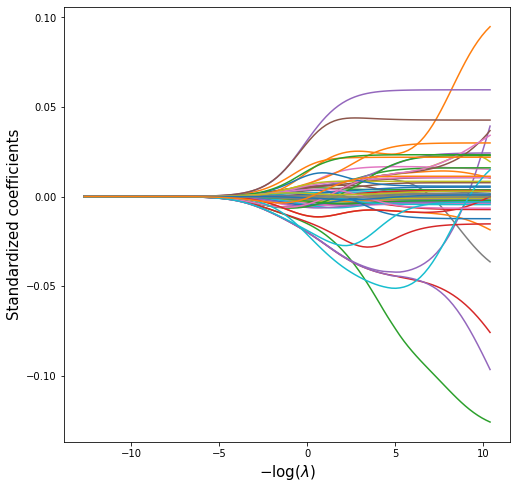

In [52]:
# Plot the graph
path_fig, ax = subplots(figsize=(8,8))
soln_path_1.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=15)
ax.set_ylabel('Standardized coefficients', fontsize=15);
#ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.005))
#ax.set_title('Ridge Regression Coefficient Path', fontsize=21); 
#ax.set_ylim([-0.1,0.4]);
# save the figure
plt.savefig('ridge_no_ban.png', format = 'png',dpi=300, bbox_inches='tight')

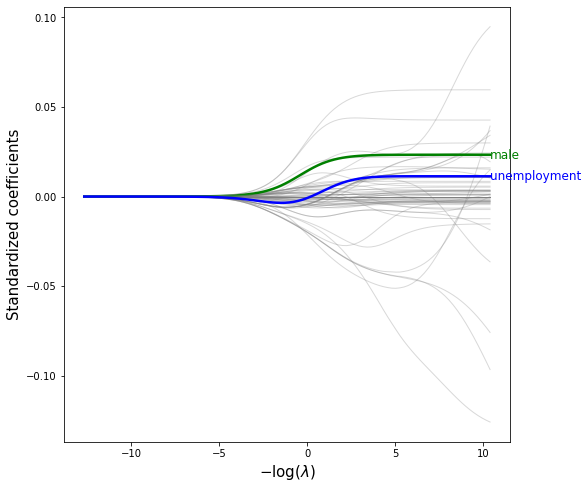

In [53]:
# Subgroup: offenders not subject to the ban 

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))

# Define the covariates you want to highlight, their corresponding labels, and custom colors
highlight_covariates = {
    'unemp_rate': {'label': 'unemployment', 'color': 'blue'},
    'male': {'label': 'male', 'color': 'green'}
}

# Plot each covariate line
for covariate in soln_path_1.columns:
    if covariate in highlight_covariates:
        # Highlight these covariates with specific colors and bold lines
        label_info = highlight_covariates[covariate]
        soln_path_1[covariate].plot(ax=ax, label=label_info['label'], color=label_info['color'], linewidth=2.5, alpha=1.0)
        
        # Add label to the right side of the curve (at the last point)
        rightmost_point = soln_path_1[covariate].index[-1]  # Last index
        rightmost_value = soln_path_1[covariate].iloc[-1]   # Last value
        ax.text(x=rightmost_point, y=rightmost_value, 
                s=label_info['label'], fontsize=12, color=label_info['color'],
                verticalalignment='center', horizontalalignment='left')
    else:
        # Fade other covariates with lighter color and transparency
        soln_path_1[covariate].plot(ax=ax, color='gray', linewidth=1, alpha=0.3)

# Add labels for axes
ax.set_xlabel('$-\log(\lambda)$', fontsize=15)
ax.set_ylabel('Standardized coefficients', fontsize=15)

# Save the figure
plt.savefig('ridge_no_ban_labels.png', format='png', dpi=300, bbox_inches='tight')

# Show plot
plt.show();

In [54]:
################################### CLASSIFICATION TREES ########################################################

In [55]:
# Load packages
import sklearn.model_selection as skm
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR,
      GradientBoostingClassifier as GBC,
     RandomForestClassifier as RFC)

In [56]:
# classification Tree
clf = DTC(criterion='entropy',
          max_depth=3,
          random_state=0)
clf.fit(X,Y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

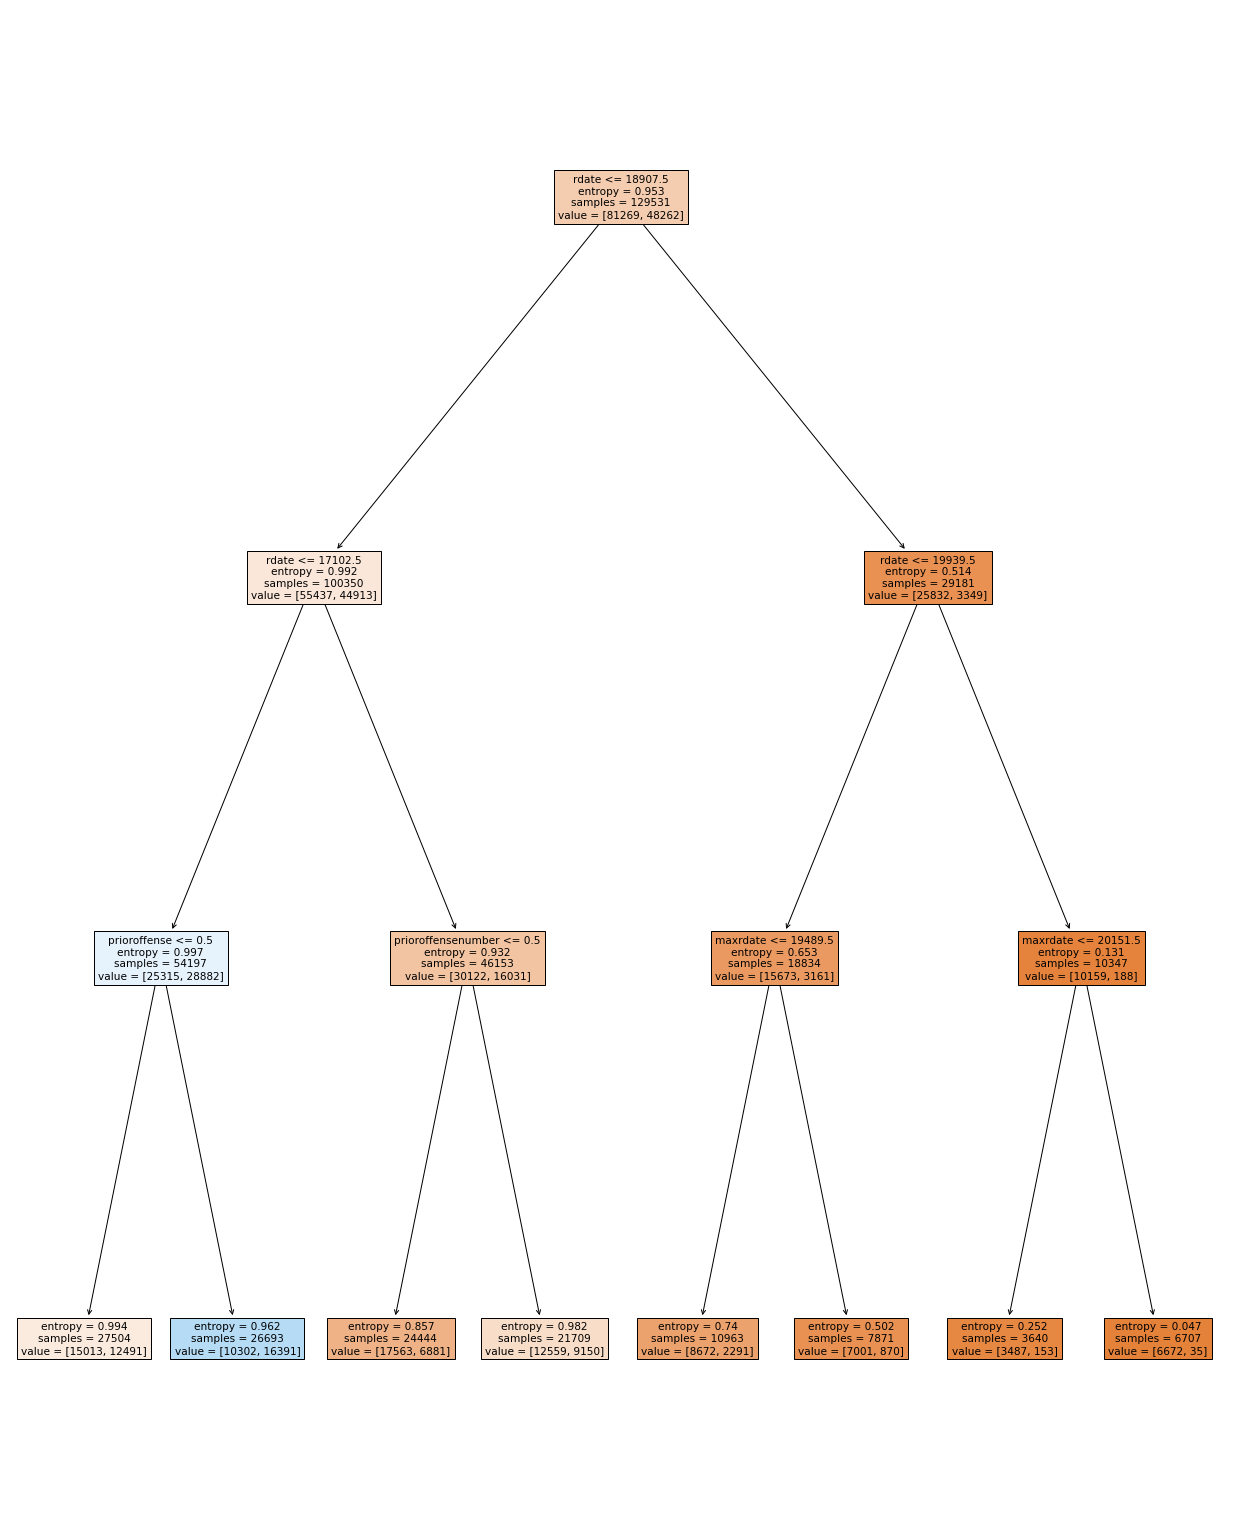

In [57]:
# Plot the tree
feature_names = X.columns
ax = subplots(figsize=(22,28))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax, filled = True);

In [91]:
############################################### Macthing ########################################################

In [60]:
import pandas as pd
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors

# Load dataset
data = pd.read_stata('updated_fl.dta')

# Define treatment and covariates
treatment = data['ban']
covariates = data.drop(columns=["anyrecid", "ban", "offenderid", "county", "placebodrug"])

# Convert all covariates to numeric and check for missing or infinite values
for column in covariates.columns:
    covariates[column] = pd.to_numeric(covariates[column], errors='coerce')

# Check for missing or infinite values
print("Missing values before handling:")
print(covariates.isnull().sum())
print("\nInfinite values before handling:")
print((covariates == float("inf")).sum())

# Handle missing values in covariates
covariates.fillna(covariates.mean(), inplace=True)  

# Replace infinities with the maximum of each column
for column in covariates.columns:
    max_value = covariates[column].max() if not covariates[column].isnull().all() else 0
    covariates[column].replace([float("inf"), -float("inf")], max_value, inplace=True)

# Recheck for NaN or infinite values after handling
print("\nMissing values after handling:")
print(covariates.isnull().sum())
print("\nInfinite values after handling:")
print((covariates == float("inf")).sum())

# Handle missing values in treatment variable
if treatment.isnull().sum() > 0:
    print("Dropping rows with missing treatment values.")
    data = data.dropna(subset=['ban'])  
    treatment = data['ban']  

# Check again for missing values in treatment variable
print("\nMissing values in treatment variable after handling:")
print(treatment.isnull().sum())

# Handle missing values in covariates again
covariates = covariates.loc[data.index]  # Ensure covariates align with data after dropping

# Drop rows with any missing values in covariates
covariates = covariates.dropna()

# Ensure that treatment variable aligns with covariates
treatment = treatment[covariates.index]

# Check if there are still missing values
print("\nMissing values in covariates after alignment:")
print(covariates.isnull().sum())

# Check if covariates DataFrame is empty
if covariates.empty:
    print("Covariates DataFrame is empty. No rows remaining after dropping missing values.")
else:
    # Estimate propensity scores
    logit = sm.Logit(treatment, covariates).fit()
    data['propensity_score'] = logit.predict()

    # Ensure propensity scores were calculated
    if 'propensity_score' in data.columns:
        # Match based on nearest neighbor in propensity score
        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(data[data['ban'] == 0]['propensity_score'].values.reshape(-1, 1))
        distances, indices = nn.kneighbors(data[data['ban'] == 1]['propensity_score'].values.reshape(-1, 1))

        # Create matched dataset
        matched_data = pd.concat([data[data['ban'] == 1], data[data['ban'] == 0].iloc[indices.flatten()]])

        # Proceed with analysis of treatment effect
    else:
        print("Propensity score calculation was not successful.")

Missing values before handling:
index             0
date              0
adate             0
redate            0
rdate         77368
              ...  
preoct97          0
placebosmd     1302
year          88847
month         88847
unemp_rate    88847
Length: 83, dtype: int64

Infinite values before handling:
index         0
date          0
adate         0
redate        0
rdate         0
             ..
preoct97      0
placebosmd    0
year          0
month         0
unemp_rate    0
Length: 83, dtype: int64


/var/folders/1x/fvyxnz7d5db2mw8jz8k69snr0000gn/T/ipykernel_27203/1946931971.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  covariates[column].replace([float("inf"), -float("inf")], max_value, inplace=True)



Missing values after handling:
index         0
date          0
adate         0
redate        0
rdate         0
             ..
preoct97      0
placebosmd    0
year          0
month         0
unemp_rate    0
Length: 83, dtype: int64

Infinite values after handling:
index         0
date          0
adate         0
redate        0
rdate         0
             ..
preoct97      0
placebosmd    0
year          0
month         0
unemp_rate    0
Length: 83, dtype: int64
Dropping rows with missing treatment values.

Missing values in treatment variable after handling:
0

Missing values in covariates after alignment:
index         0
date          0
adate         0
redate        0
rdate         0
             ..
preoct97      0
placebosmd    0
year          0
month         0
unemp_rate    0
Length: 83, dtype: int64
Covariates DataFrame is empty. No rows remaining after dropping missing values.


In [1]:
################################ MORE SUMMARY STATISTICS ##########################################################

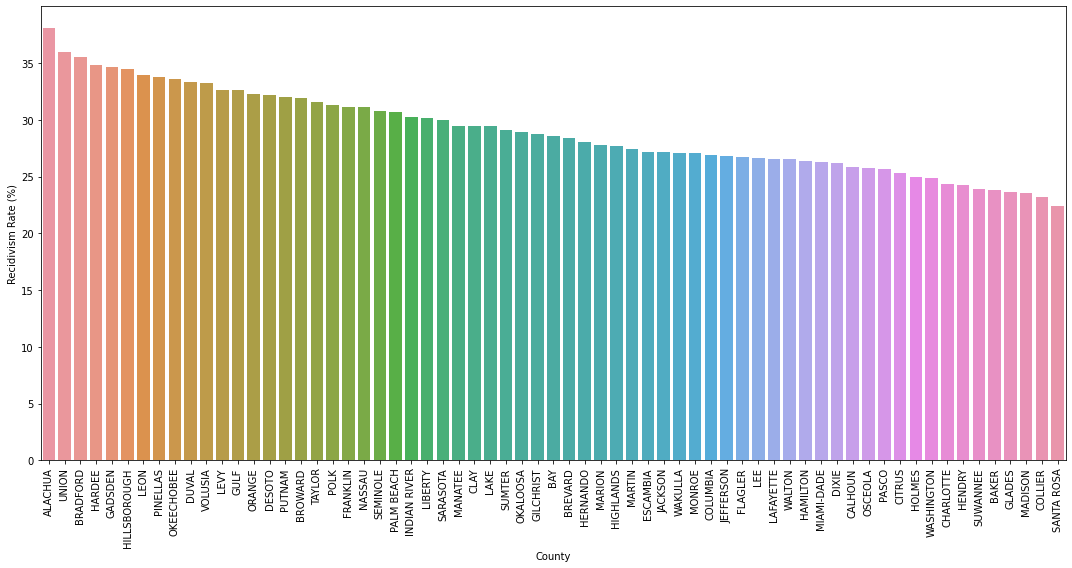

In [61]:
### Recidivism rates per county
# Import dataset
import pandas as pd
import seaborn as sns

dta = pd.read_stata('updated_fl.dta')

# Calculate recidivism rate per county 
recidivism_by_county = dta.groupby('county')['anyrecid'].mean() * 100
recidivism_by_county = recidivism_by_county.sort_values(ascending=False)
recidivism_by_county = recidivism_by_county.drop("")

# Create a bar plot
plt.figure(figsize=(15, 8))
sns.barplot(x=recidivism_by_county.index, y=recidivism_by_county.values)
plt.xticks(rotation=90)
#plt.title('Recidivism Rate by County in Florida')
plt.xlabel('County')
plt.ylabel('Recidivism Rate (%)')

plt.tight_layout()
plt.savefig('county.png',format='png', dpi=300, bbox_inches='tight')
plt.show();

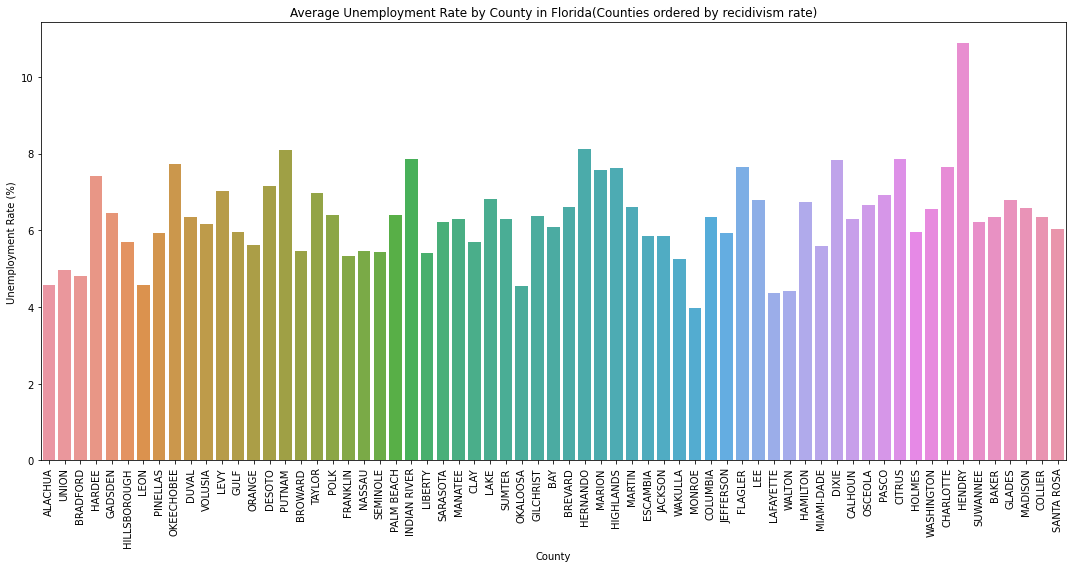

In [62]:
### Average unemployment rate per county
# Get the county order from previous recidivism graph
county_order = recidivism_by_county.index

# Calculate mean unemployment rate per county and reorder according to recidivism order
unemployment_by_county = dta.groupby('county')['unemp_rate'].mean()
unemployment_by_county = unemployment_by_county[county_order]

# Create bar plot
plt.figure(figsize=(15, 8))
sns.barplot(x=unemployment_by_county.index, y=unemployment_by_county.values)
plt.xticks(rotation=90)
plt.title('Average Unemployment Rate by County in Florida\
(Counties ordered by recidivism rate)')
plt.xlabel('County')
plt.ylabel('Unemployment Rate (%)')

# Adjust layout
plt.tight_layout()
plt.savefig('unemployment.png', format = 'png',dpi=300, bbox_inches='tight')
plt.show();

In [63]:
######################################### FIXED EFFECTS REGRESSION ###############################################

In [64]:
# Clean the data by removing missing values
df_clean = dta.dropna(subset=['ban', 'unemp_rate', 'age', 'sex', 'anyrecid'])

# Run the logit model with year fixed effects
formula_fe = 'anyrecid ~ ban + unemp_rate + ban*unemp_rate + C(sex) + C(releaseyear)'
logit_fe = smf.logit(formula=formula_fe, data=df_clean).fit()

print(logit_fe.summary())

         Current function value: 0.542533
         Iterations: 35


/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:               anyrecid   No. Observations:               403395
Model:                          Logit   Df Residuals:                   403371
Method:                           MLE   Df Model:                           23
Date:                Sun, 03 Nov 2024   Pseudo R-squ.:                  0.1167
Time:                        10:00:01   Log-Likelihood:            -2.1886e+05
converged:                      False   LL-Null:                   -2.4776e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.2339      0.067     -3.475      0.001      -0.366      -0.102
C(sex)[T.M]                  0.6334      0.013     50.060      0.000       0.609       0.

In [65]:
###################################### DIRECTED ACYCLIC GRAPH (DAG) ###############################################

/var/folders/1x/fvyxnz7d5db2mw8jz8k69snr0000gn/T/ipykernel_27203/3958718416.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


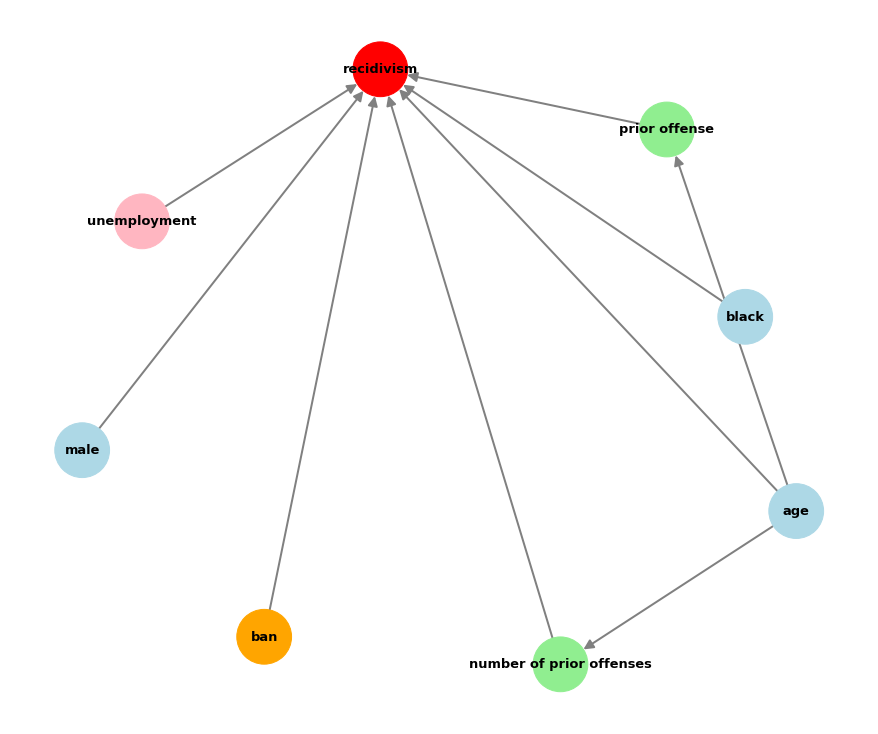

In [66]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed acyclic graph
G = nx.DiGraph()

# Define variables in different categories
demographic_vars = ['age', 'black', 'male']
criminal_vars = ['prior offense', 'number of prior offenses']
economic_vars = ['unemployment']
policy_vars = ['ban']
outcome_var = ['recidivism']

# Add all nodes to the graph
all_vars = demographic_vars + criminal_vars + economic_vars + policy_vars + outcome_var
for var in all_vars:
    G.add_node(var)

# Define relationships by adding edges
for var in demographic_vars:
    G.add_edge(var, 'recidivism')
for var in criminal_vars:
    G.add_edge(var, 'recidivism')
G.add_edge('unemployment', 'recidivism')
G.add_edge('ban', 'recidivism')
G.add_edge('age', 'prior offense')
G.add_edge('age', 'number of prior offenses')

# Draw the graph with adjusted arrow settings
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=5.9, iterations=50)

# Define node colors
node_colors = []
for node in G.nodes():
    if node == 'recidivism':
        node_colors.append('red')
    elif node == 'ban':
        node_colors.append('orange')
    elif node == 'unemployment':
        node_colors.append('lightpink')
    elif node in ['prior offense', 'number of prior offenses']:
        node_colors.append('lightgreen')
    else:
        node_colors.append('lightblue')  # Default color for other nodes

# Draw nodes and edges with specified colors
nx.draw(G, pos, node_size=3000, node_color=node_colors,
        edge_color='grey', arrows=True, arrowstyle='-|>', arrowsize=20, width=2)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=13, font_weight='bold')

# Save and display the plot
plt.savefig('dag.png', format='png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show();

/var/folders/1x/fvyxnz7d5db2mw8jz8k69snr0000gn/T/ipykernel_27203/2133959281.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


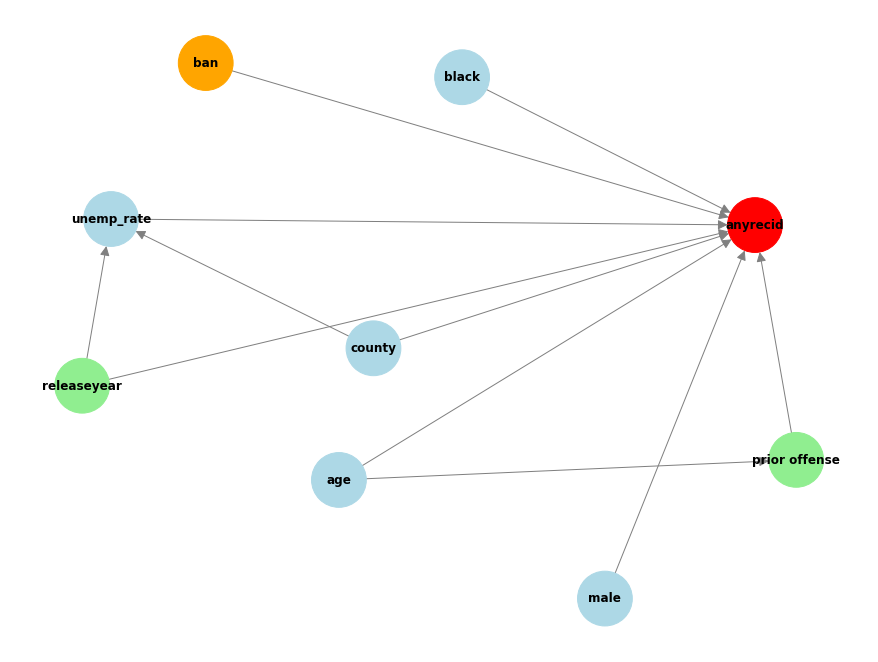

In [97]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed acyclic graph
G = nx.DiGraph()

# Define variables in different categories
demographic_vars = ['age', 'black', 'male','county']
criminal_vars = ['prior offense','releaseyear']
economic_vars = ['unemp_rate']
policy_vars = ['ban']
outcome_var = ['anyrecid']

# Add all nodes to the graph
all_vars = demographic_vars + criminal_vars + economic_vars + policy_vars + outcome_var
for var in all_vars:
    G.add_node(var)

# Define relationships by adding edges
for var in demographic_vars:
    G.add_edge(var, 'anyrecid')
for var in criminal_vars:
    G.add_edge(var, 'anyrecid')
G.add_edge('unemp_rate', 'anyrecid')
G.add_edge('ban', 'anyrecid')
G.add_edge('age', 'prior offense')
G.add_edge('releaseyear', 'unemp_rate')
G.add_edge('county','unemp_rate')

# Draw the graph with adjusted arrow settings
plt.figure(figsize=(12, 9))
pos = nx.spring_layout(G, k=0.9, iterations=50)

# Define node colors
node_colors = []
for node in G.nodes():
    if node == 'anyrecid':
        node_colors.append('red')
    elif node == 'ban':
        node_colors.append('orange')
    elif node == 'unemployment':
        node_colors.append('lightpink')
    elif node in ['prior offense', 'number of prior offenses','releaseyear']:
        node_colors.append('lightgreen')
    else:
        node_colors.append('lightblue')  # Default color for other nodes

# Draw nodes and edges with specified colors
nx.draw(G, pos, node_size=3000, node_color=node_colors,
        edge_color='grey', arrows=True, arrowstyle='-|>', arrowsize=20, width=1)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Save and display the plot
#plt.savefig('dag_control_1.png', format='png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show();

In [98]:
# Load packages
from dowhy import CausalModel
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from pandas import concat
from matplotlib.pyplot import subplots
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, lasso_path, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [99]:
# When controlling for the release year
# Setting causal model
dtas = dta.dropna()
model = CausalModel(data=dtas,
                    treatment='unemp_rate',
                    outcome='anyrecid',
                    graph=G)

# Identify the estimand
estimand = model.identify_effect()
estimate = model1.estimate_effect(identified_estimand=estimand,
                               method_name='backdoor.linear_regression')
print(estimate)

/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/dowhy/causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                      
────────────(E[anyrecid|county,releaseyear])
d[unempᵣₐₜₑ]                                
Estimand assumption 1, Unconfoundedness: If U→{unemp_rate} and U→anyrecid then P(anyrecid|unemp_rate,county,releaseyear,U) = P(anyrecid|unemp_rate,county,releaseyear)

## Realized estimand
b: anyrecid~unemp_rate+county+releaseyear+unemp_rate*releaseyear+unemp_rate*male+unemp_rate*black+unemp_rate*age+unemp_rate*ban
Target units: ate

## Estimate
Mean value: 0.002890408797722399
### Conditional Estimates
Empty DataFrame
Columns: [index, offenderid, date, adate, redate, rdate, county1, releaseyear, releasemonth, after, dist, distnoab, distn2, distn3, distn4, fullbanafter, fullbanbefore, concurrent_sentence, drugoffense, traffoffense, otheroffense, smd, traffmar, traffcoc, traffher, traffamph, traffill

/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/dowhy/causal_estimator.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[prefix + str(em)] = pd.qcut(data[em], num_quantiles, duplicates="drop")
/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/dowhy/causal_estimator.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[prefix + str(em)] = pd.qcut(data[em], num_quantiles, duplicates="drop")
/Users/edithsimochemo/opt/anaconda3/lib/python3.9/site-packages/dowhy/causal